# 暗闇での物体検知・識別
## 目的
画像解析や物体検知技術は自動車などで今後も広がっていく技術である。しかし、雨天時や暗闇、明度に差のあるシチュエーションではセンサーや認識が誤作動を起こすことがある。
ここでは、暗闇で撮影された画像、もしくは、暗闇での写真となるように画像にノイズ加工を行ったデータに対して、CNNが正しく物体検出ができることを実現することを目指す。

## 対象
様々なシチュエーションの中で、ここでは暗闇での撮影を前提に処理を考える。

## 参考論文・文献
ディープラーニングを用いて暗闇の中で「見えない」オブジェクトを明らかにする（2019年 1月31日）https://ai-scholar.tech/articles/machine-learning/ai-dark-69
### Qiita
https://qiita.com/TrashBoxx/items/2d441e46643f73c0ca19

### 参考講義/コーディング演習
Section: 9,10


## 実装の方針


1.   Cifar10と以下に記述するCBIU2019を対象に分析を行う。
2.   Cifar10とCBIUに共通するカテゴリである、[cat, dog, Car(=automobile), Ship(=Boat)]を対象とし、後者のCarとShipに関しては精度が落ちる可能性があるため別途検証する。
3.   暗闇での物体検知のため、
      * Cifar10事前学習済みモデル単体による検知
      * Cifar10の学習済みモデルに対しCBIUによるファインチューニングを施したパターン
      * CBIU単体のResNetによる学習をしたパターン
      上記3パターンを試み、結果を比較する。








### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Mounted at /content/drive


In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install torch==1.13.0 torchvision==0.14.0
else:
    print("Not Google Colab")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121


In [ ]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, wide_resnet50_2
import os
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm

np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
    torch.backends.cudnn.benchmark = True

# GPU が利用できる場合は、GPU上で学習を行います。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### データセットの準備

データセットには、cifar10 とCBIU2019 を使用します。

cifar10 は10種類のクラスを含まれており、  
学習データ 50000枚、テストデータ 10000枚で構成されています。

データは 3チャンネル(RGB)の縦横 32×32 の配列`(3, 32, 32)`となっています。


### CBIU2019について
このデータセットは低照度環境下での物体検出の研究のためのデータセットです。

URL：http://cs-chan.com/doc/cviu.pdf

GitHub：https://github.com/cs-chan/Exclusively-Dark-Image-Dataset

7367枚の画像と 12個のオブジェクトクラスを用意している。


In [ ]:
#kaggleから画像データセットを取得し、サンプルで確認する

dataset_name = "mangosata/exclusivelydarkimagedataset-from-cschan"

!pip install -q kaggle
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/colab/kaggle.json /root/.kaggle/

!git clone https://github.com/tttza/kaggle_dataset_downloader.git
from kaggle_dataset_downloader import download_dataset
download_dataset.get_dataset(dataset_name)


# ZIPファイルのパス
zip_file_path = "/content/download/exclusivelydarkimagedataset-from-cschan/exclusivelydarkimagedataset-from-cschan.zip"

# ZIPファイルを解凍
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dark_images")

# 解凍されたデータセットのディレクトリを指定
dataset_path = "/content/dark_images"

# ディレクトリ内の画像ファイルのリストを取得
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg')):
            image_files.append(os.path.join(root, file))

# サンプル画像を表示
num_samples = 5  # 表示するサンプル画像の数
for i in range(min(num_samples, len(image_files))):
    img = Image.open(image_files[i])
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Sample {i+1}')
    plt.show()


In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# Cifer10のデータの前処理

# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 10

# 学習データに適用する前処理
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),   # 短い辺の長さがresizeの大きさになる
    transforms.RandomHorizontalFlip(),          # ランダムに左右に反転する
    transforms.ToTensor(),                      # Torchテンソルに変換
    transforms.Normalize(mean, std)             # 色情報の標準化
])
trainset10 = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=train_transform
)

num_data =1000
num_classes = 4
# 船: 8, 自動車: 1, 犬: 5, 猫: 3 のインデックス
idx_list = [8, 1, 5, 3]

# 学習データから指定カテゴリの画像を抽出
mini_data = [[] for x in range(num_classes)]
for img, tgt in zip(trainset10.data, trainset10.targets):
    if tgt in idx_list:
        class_index = idx_list.index(tgt)
        if len(mini_data[class_index]) < num_data:
            mini_data[class_index].append(img)
mini_data = np.array(mini_data, dtype=trainset10.data.dtype).reshape(-1, 32, 32, 3)

# 学習データ用の正解ラベルを作成
mini_targets = []
for i in range(num_classes):
    tgt = [i] * num_data
    mini_targets += tgt

# 学習データの置き換え
trainset10.data = mini_data
trainset10.targets = mini_targets

# 学習データのデータローダ
trainloader10 = torch.utils.data.DataLoader(
    trainset10, batch_size=batch_size,
    shuffle=True, num_workers=2
)

# テストデータに適用する前処理
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 短い辺の長さがresizeの大きさになる
    transforms.ToTensor(),              # Torchテンソルに変換
    transforms.Normalize(mean, std)     # 色情報の標準化
])
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=test_transform
)

# テストデータから指定カテゴリの画像を抽出
mini_data = [[] for x in range(num_classes)]
for img, tgt in zip(testset.data, testset.targets):
    if tgt in idx_list:
        class_index = idx_list.index(tgt)
        mini_data[class_index].append(img)
mini_data = np.array(mini_data, dtype=testset.data.dtype).reshape(-1, 32, 32, 3)

# テストデータ用の正解ラベルを作成
mini_targets = []
for i in range(num_classes):
    tgt = [i] * 1000
    mini_targets += tgt

# テストデータの置き換え
testset.data = mini_data
testset.targets = mini_targets

# テストデータのデータローダ
testloader10 = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,
    shuffle=False, num_workers=2
)

# クラスラベルの定義
classes = ['ship', 'car', 'dog', 'cat']

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 学習データからサンプル画像を表示
dataiter = iter(trainloader10)
images10, labels10 = next(dataiter)

# 画像を表示
imshow(torchvision.utils.make_grid(images10))
# ラベルを表示
print(' '.join(f'{classes[labels10[j]]}' for j in range(batch_size)))

# テストデータからサンプル画像を表示
dataiter10 = iter(testloader10)
images, labels = next(dataiter10)

# 画像を表示
imshow(torchvision.utils.make_grid(images))
# ラベルを表示
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

Dark Imagesの中から今回分析対象とする4クラスを抽出しデータセットにし直す。

学習データのサンプル:


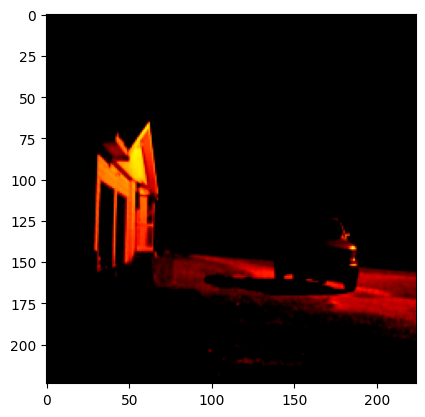

ラベル: Car
画像パス: /content/dark_images/Car/2015_02428.jpg


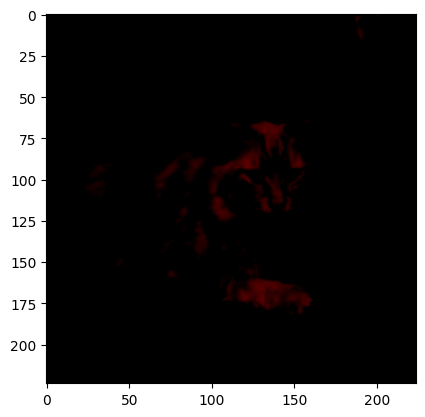

ラベル: Cat
画像パス: /content/dark_images/Cat/2015_03686.jpg


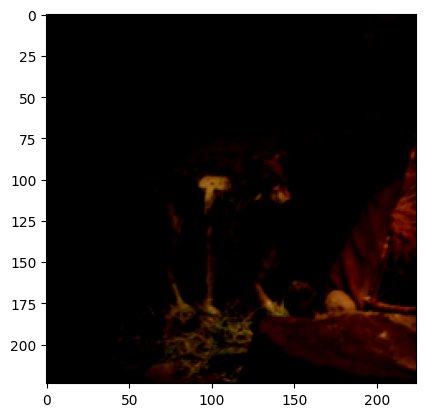

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05265.jpg


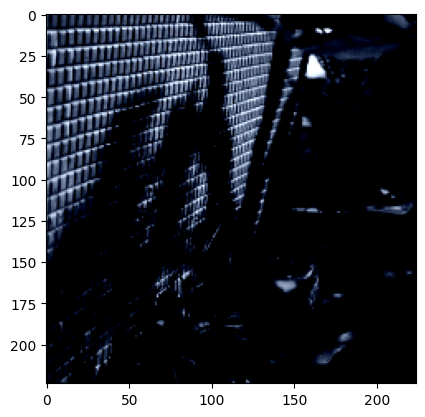

ラベル: Cat
画像パス: /content/dark_images/Cat/2015_03186.jpg
テストデータのサンプル:


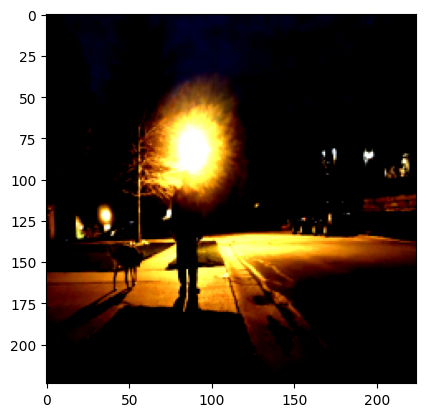

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_04980.jpg


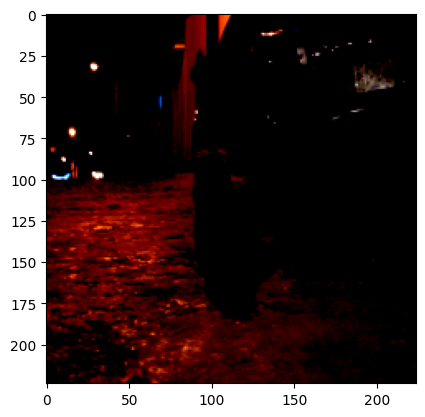

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05075.jpg


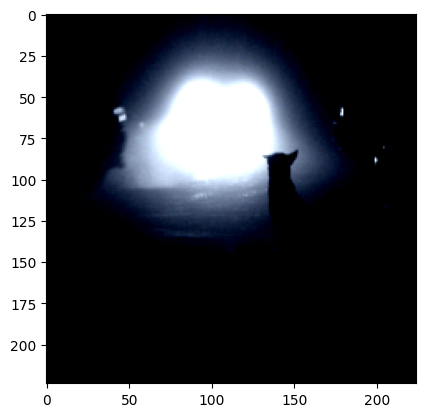

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05609.jpg


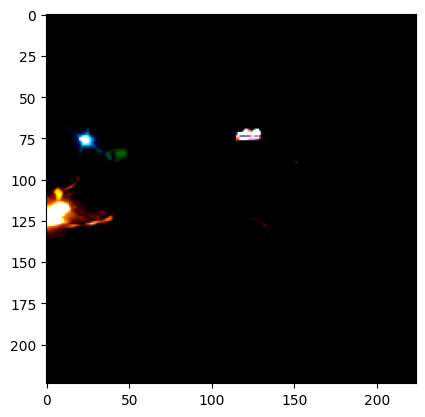

ラベル: Dog
画像パス: /content/dark_images/Dog/2015_05638.jpg


In [62]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# データセットのパス
dataset_path = "/content/dark_images"

# カテゴリのマッピング
categories = {
    'Dog': 0,
    'Cat': 1,
    'Boat': 2,
    'Car': 3
}

# クラスラベルのリスト
class_names = list(categories.keys())

# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 8

# 前処理の設定
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# カスタムデータセットクラスの定義
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.paths = []

        for category in categories.keys():
            category_path = os.path.join(root_dir, category)
            label = categories[category]
            for root, _, files in os.walk(category_path):
                for file in files:
                    if file.endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(root, file)
                        self.images.append(img_path)
                        self.labels.append(label)
                        self.paths.append(img_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

# データセットの作成
train_dataset = CustomDataset(root_dir=dataset_path, transform=data_transform)
test_dataset = CustomDataset(root_dir=dataset_path, transform=data_transform)

# データローダの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 画像を表示する関数
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 各クラスのサンプルを表示する関数
def show_samples(loader, class_names, num_samples=4):
    dataiter = iter(loader)
    images, labels, paths = next(dataiter)

    # バッチから指定した数のサンプルを表示
    for i in range(num_samples):
        imshow(images[i])
        print(f'ラベル: {class_names[labels[i].item()]}')
        print(f'画像パス: {paths[i]}')

# 学習データのサンプルを表示
print("学習データのサンプル:")
show_samples(train_loader, class_names, num_samples=4)

# テストデータのサンプルを表示
print("テストデータのサンプル:")
show_samples(test_loader, class_names, num_samples=4)


## モデル群の定義

今回は計算の高速化と精度の向上を目的にResNet50をベースに講義で使用したWidebottleneckと同様のものを使用する。

In [11]:
class WideBottleneck(nn.Module): # コーディング演習とほぼ同様
    def __init__(
        self,
        input_dim,
        output_dim,
        stride=1,
        downsample=False
    ):
        super(WideBottleneck, self).__init__()

        hidden_dim = output_dim * 2

        self.conv1 = nn.Conv2d(
            input_dim, hidden_dim,
            kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(
            hidden_dim, hidden_dim,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.conv3 = nn.Conv2d(
            hidden_dim, output_dim * 4,
            kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    input_dim, output_dim * 4,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_dim * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        shortcut = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            shortcut = self.downsample(shortcut)

        x += shortcut
        x = self.relu(x)

        return x

In [12]:
# torchvision より実装済みの WideResNet50 を呼び出し
model_wide_resnet50 = wide_resnet50_2(pretrained=True)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
model_wide_resnet50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [14]:
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth", progress=True)
model_wide_resnet50.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [15]:
feat_dim = model_wide_resnet50.fc.in_features
model_wide_resnet50.fc = nn.Linear(feat_dim, 4) #4クラス分類タスクなので出力層を調整
print(model_wide_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [ ]:
import matplotlib.pyplot as plt

# optimizer #学習済みモデルに対して、標準的なデータセットの学習なのでハイパパラメータはそのままで一度実行する。
optimizer = torch.optim.SGD(model_wide_resnet50.fc.parameters(), lr=0.002, momentum=0.8)

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(7):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader10): #Cifar10
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader10): #Cifar10
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

# ハイパーパラメータによる精度の変化
# lr=0.001 momentum=0.9→（Epoch1で77.90％→Epoch7で79.40％）
# lr=0.002 momentum=0.8→(Epoch1で73.7%→Epoch7で84.17%)
# lr=0.005 momentum0.9→（56.90%→76.33%）

Epoch: 1


100%|██████████| 400/400 [00:38<00:00, 10.41it/s]


Train Accuracy: 36.88%


100%|██████████| 400/400 [00:13<00:00, 29.64it/s]


Test Accuracy: 41.20%
Epoch: 2


100%|██████████| 400/400 [00:38<00:00, 10.31it/s]


Train Accuracy: 39.15%


100%|██████████| 400/400 [00:13<00:00, 29.53it/s]


Test Accuracy: 47.83%
Epoch: 3


100%|██████████| 400/400 [00:39<00:00, 10.23it/s]


Train Accuracy: 39.75%


100%|██████████| 400/400 [00:13<00:00, 29.39it/s]


Test Accuracy: 30.38%
Epoch: 4


100%|██████████| 400/400 [00:39<00:00, 10.18it/s]


Train Accuracy: 38.67%


 10%|█         | 42/400 [00:01<00:12, 29.82it/s]

100%|██████████| 328/328 [00:10<00:00, 30.23it/s]
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning

全体の精度: 13.860252004581902%
クラス 0 の精度: 4.768583450210379%
クラス 1 の精度: 14.705882352941176%
クラス 2 の精度: 29.45859872611465%
クラス 3 の精度: 6.914893617021277%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

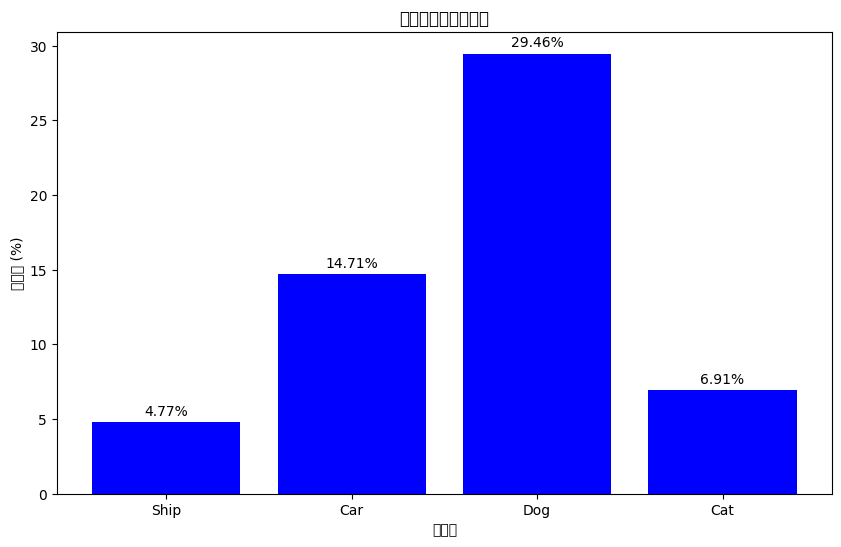

In [33]:
# DarkImagesデータセットをCifar10による学習結果で予測してみる
import torch.nn as nn

import matplotlib.pyplot as plt
# import numpy as np
from tqdm import tqdm

# データセットを含むtrain_loaderの設定
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

# データセットを含むtest_loaderの設定
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=2
)

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モードへの変更
model_wide_resnet50.eval()

# 正解数と全体数の初期化
total = 0
correct = 0

# 各クラスの正解数と全体数の初期化
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

# テストデータの評価
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # 各クラスの正解数と全体数を更新
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # 全体の正解数と全体数を更新
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 全体精度の表示
print(f"全体の精度: {100 * correct / total}%")

# 各クラスの精度の表示
for i in range(num_classes):
    print(f"クラス {i} の精度: {100 * class_correct[i] / class_total[i]}%")

# 各クラスの精度をグラフで表示
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Ship', 'Car', 'Dog', 'Cat']  # クラスのラベル

# 棒グラフの描画
bar = ax.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(num_classes)], color='b')

# グラフの設定
ax.set_xlabel('クラス')
ax.set_ylabel('正解率 (%)')
ax.set_title('各クラスの識別精度')

# 棒グラフに数値を表示
for rect in bar:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


異なるハイパーパラメータで学習を試みる




 lr=0.003, momentum=0.9のケース

Epoch: 1


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Train Accuracy: 49.52%


100%|██████████| 400/400 [00:13<00:00, 29.97it/s]


Test Accuracy: 60.77%
Epoch: 2


100%|██████████| 400/400 [00:41<00:00,  9.72it/s]


Train Accuracy: 57.88%


100%|██████████| 400/400 [00:13<00:00, 29.87it/s]


Test Accuracy: 70.25%
Epoch: 3


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Train Accuracy: 66.45%


100%|██████████| 400/400 [00:13<00:00, 29.62it/s]


Test Accuracy: 80.60%
Epoch: 4


100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Train Accuracy: 69.90%


100%|██████████| 400/400 [00:13<00:00, 29.34it/s]


Test Accuracy: 84.12%
Epoch: 5


100%|██████████| 400/400 [00:41<00:00,  9.55it/s]


Train Accuracy: 72.95%


100%|██████████| 400/400 [00:13<00:00, 29.48it/s]


Test Accuracy: 84.42%
Epoch: 6


100%|██████████| 400/400 [00:42<00:00,  9.50it/s]


Train Accuracy: 74.00%


100%|██████████| 400/400 [00:13<00:00, 29.39it/s]


Test Accuracy: 84.35%
Epoch: 7


100%|██████████| 400/400 [00:42<00:00,  9.47it/s]


Train Accuracy: 74.88%


100%|██████████| 400/400 [00:13<00:00, 29.23it/s]


Test Accuracy: 84.75%


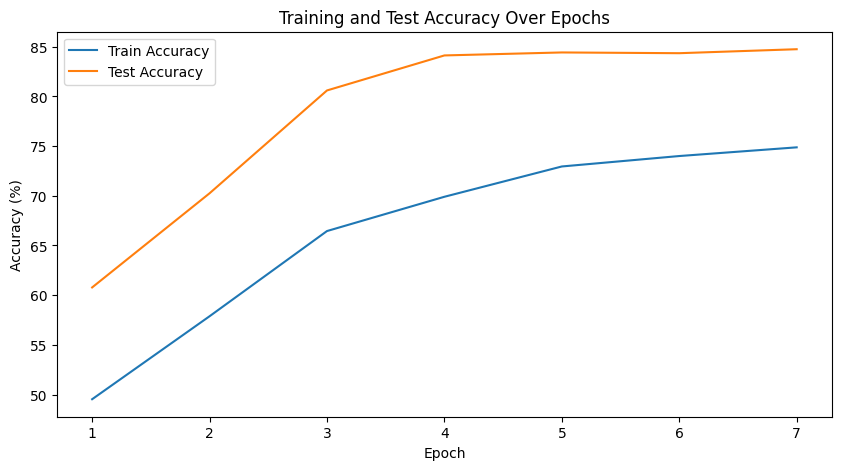

In [35]:
# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50.parameters(), lr=0.003, momentum=0.9)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(7):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader10): # cifar 10
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader10): # Cifar10
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()



100%|██████████| 328/328 [00:09<00:00, 34.12it/s]


全体の精度: 15.845742649866361%
クラス 0 の精度: 23.56241234221599%
クラス 1 の精度: 7.8431372549019605%
クラス 2 の精度: 2.5477707006369426%
クラス 3 の精度: 31.02836879432624%


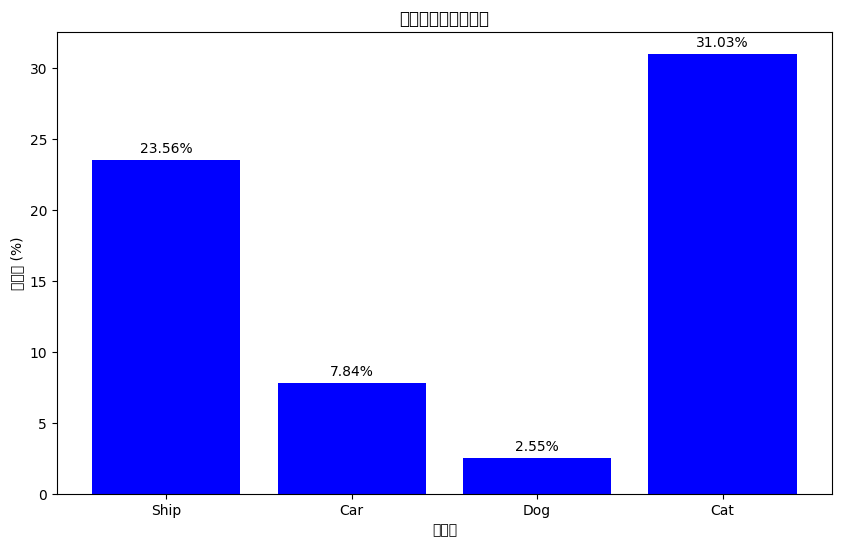

In [36]:
# データセットを含むtrain_loaderの設定
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

# データセットを含むtest_loaderの設定
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの評価モードへの変更
model_wide_resnet50.eval()

# 正解数と全体数の初期化
total = 0
correct = 0

# 各クラスの正解数と全体数の初期化
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

# テストデータの評価
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # 各クラスの正解数と全体数を更新
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # 全体の正解数と全体数を更新
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 全体精度の表示
print(f"全体の精度: {100 * correct / total}%")

# 各クラスの精度の表示
for i in range(num_classes):
    print(f"クラス {i} の精度: {100 * class_correct[i] / class_total[i]}%")

# 各クラスの精度をグラフで表示
fig, ax = plt.subplots(figsize=(10, 6))
classes = ['Ship', 'Car', 'Dog', 'Cat']  # クラスのラベル

# 棒グラフの描画
bar = ax.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(num_classes)], color='b')

# グラフの設定
ax.set_xlabel('クラス')
ax.set_ylabel('正解率 (%)')
ax.set_title('各クラスの識別精度')

# 棒グラフに数値を表示
for rect in bar:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


### 所感
性質の大きく異なるデータセット同士ではほとんど分類問題が解けないことが分かった。
したがって、二つのデータセットを混合したりなどはせず、以降はDarkImagesのみを用いて分類を行う。

# DarkImagesのみで構築したResNet50（ファインチューニング）
性質の大きく異なるものであるため学習率は0.003程度と通常よりも大きく設定。
学習済みのWideResnetを呼び出し、4クラス分類可能にし、
DarkImagesデータセットを学習させる。

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

100%|██████████| 200/200 [00:20<00:00,  9.56it/s]


Train Accuracy: 31.05%


100%|██████████| 200/200 [00:06<00:00, 29.15it/s]


Test Accuracy: 34.20%
Epoch: 2


100%|██████████| 200/200 [00:20<00:00,  9.53it/s]


Train Accuracy: 35.30%


100%|██████████| 200/200 [00:06<00:00, 29.09it/s]


Test Accuracy: 39.10%
Epoch: 3


100%|██████████| 200/200 [00:21<00:00,  9.46it/s]


Train Accuracy: 36.25%


100%|██████████| 200/200 [00:06<00:00, 28.84it/s]


Test Accuracy: 35.40%
Epoch: 4


100%|██████████| 200/200 [00:21<00:00,  9.42it/s]


Train Accuracy: 40.15%


100%|██████████| 200/200 [00:06<00:00, 28.69it/s]


Test Accuracy: 43.80%
Epoch: 5


100%|██████████| 200/200 [00:21<00:00,  9.33it/s]


Train Accuracy: 39.75%


100%|██████████| 200/200 [00:07<00:00, 28.25it/s]


Test Accuracy: 42.65%
Epoch: 6


100%|██████████| 200/200 [00:21<00:00,  9.36it/s]


Train Accuracy: 42.45%


100%|██████████| 200/200 [00:07<00:00, 28.47it/s]


Test Accuracy: 48.00%
Epoch: 7


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 46.00%


100%|██████████| 200/200 [00:07<00:00, 28.56it/s]


Test Accuracy: 46.25%


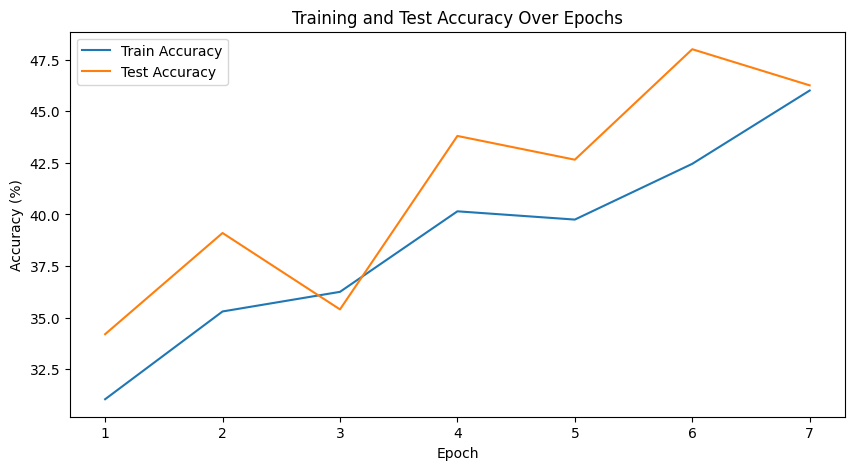

In [46]:
# torchvision より実装済みの WideResNet50 を呼び出し
model_wide_resnet50_pretrained_and_darkonly = wide_resnet50_2(pretrained=True)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50_pretrained_and_darkonly.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50_pretrained_and_darkonly.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50_pretrained_and_darkonly.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50_pretrained_and_darkonly.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)


# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_pretrained_and_darkonly.parameters(), lr=0.003, momentum=0.9)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_pretrained_and_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(7):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_pretrained_and_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_pretrained_and_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()



Epoch: 1


100%|██████████| 200/200 [00:20<00:00,  9.59it/s]


Train Accuracy: 99.10%


100%|██████████| 200/200 [00:06<00:00, 29.08it/s]


Test Accuracy: 53.35%
Epoch: 2


100%|██████████| 200/200 [00:20<00:00,  9.53it/s]


Train Accuracy: 99.50%


100%|██████████| 200/200 [00:06<00:00, 28.81it/s]


Test Accuracy: 52.85%
Epoch: 3


100%|██████████| 200/200 [00:21<00:00,  9.49it/s]


Train Accuracy: 99.30%


100%|██████████| 200/200 [00:07<00:00, 28.47it/s]


Test Accuracy: 51.70%
Epoch: 4


100%|██████████| 200/200 [00:21<00:00,  9.46it/s]


Train Accuracy: 99.45%


100%|██████████| 200/200 [00:06<00:00, 28.61it/s]


Test Accuracy: 53.60%
Epoch: 5


100%|██████████| 200/200 [00:21<00:00,  9.45it/s]


Train Accuracy: 99.45%


100%|██████████| 200/200 [00:06<00:00, 28.59it/s]


Test Accuracy: 52.40%
Epoch: 6


100%|██████████| 200/200 [00:21<00:00,  9.41it/s]


Train Accuracy: 99.70%


100%|██████████| 200/200 [00:07<00:00, 28.18it/s]


Test Accuracy: 52.55%
Epoch: 7


100%|██████████| 200/200 [00:21<00:00,  9.37it/s]


Train Accuracy: 99.85%


100%|██████████| 200/200 [00:07<00:00, 28.52it/s]


Test Accuracy: 53.80%
Epoch: 8


100%|██████████| 200/200 [00:21<00:00,  9.36it/s]


Train Accuracy: 99.70%


100%|██████████| 200/200 [00:07<00:00, 28.47it/s]


Test Accuracy: 53.45%
Epoch: 9


100%|██████████| 200/200 [00:21<00:00,  9.35it/s]


Train Accuracy: 99.65%


100%|██████████| 200/200 [00:07<00:00, 28.47it/s]


Test Accuracy: 54.05%
Epoch: 10


100%|██████████| 200/200 [00:21<00:00,  9.35it/s]


Train Accuracy: 99.65%


100%|██████████| 200/200 [00:07<00:00, 28.11it/s]


Test Accuracy: 51.95%
Epoch: 11


100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


Train Accuracy: 99.50%


100%|██████████| 200/200 [00:07<00:00, 28.36it/s]


Test Accuracy: 54.50%
Epoch: 12


100%|██████████| 200/200 [00:21<00:00,  9.33it/s]


Train Accuracy: 99.55%


100%|██████████| 200/200 [00:07<00:00, 28.34it/s]


Test Accuracy: 53.75%


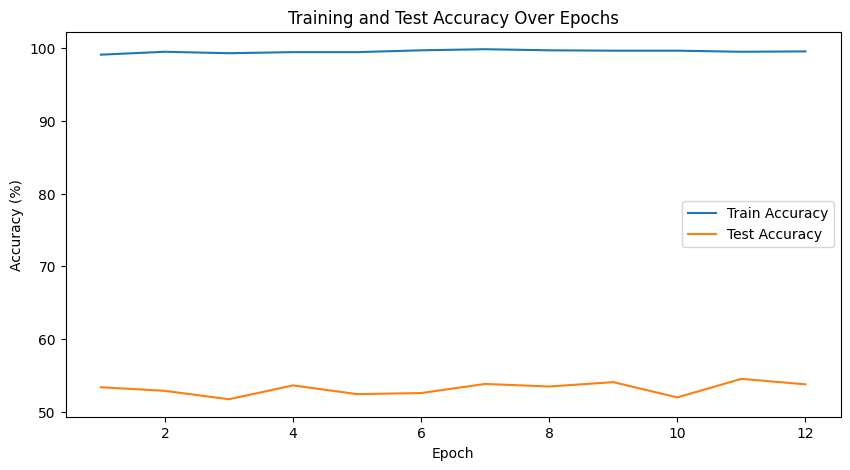

In [63]:
# 反復回数を増やし

# DarkImagesのTrainloaderとTestloader

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_pretrained_and_darkonly.parameters(), lr=0.003, momentum=0.8)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_pretrained_and_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

# エポックを12にする
for epoch in range(12):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_pretrained_and_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_pretrained_and_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_pretrained_and_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 13), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()



①Trainデータへのフィットが高く、テストデータへのフィットが低い


#DarkImagesImagesのみで構築するファインチューニングでないパターン

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


Train Accuracy: 29.55%


100%|██████████| 200/200 [00:07<00:00, 28.51it/s]


Test Accuracy: 36.30%
Epoch: 2


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


Train Accuracy: 34.75%


100%|██████████| 200/200 [00:06<00:00, 28.59it/s]


Test Accuracy: 36.75%
Epoch: 3


100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


Train Accuracy: 38.65%


100%|██████████| 200/200 [00:07<00:00, 28.22it/s]


Test Accuracy: 40.85%
Epoch: 4


100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


Train Accuracy: 40.05%


100%|██████████| 200/200 [00:07<00:00, 28.09it/s]


Test Accuracy: 40.75%
Epoch: 5


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


Train Accuracy: 40.95%


100%|██████████| 200/200 [00:07<00:00, 28.33it/s]


Test Accuracy: 43.10%
Epoch: 6


100%|██████████| 200/200 [00:21<00:00,  9.34it/s]


Train Accuracy: 41.95%


100%|██████████| 200/200 [00:06<00:00, 28.65it/s]


Test Accuracy: 46.55%
Epoch: 7


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


Train Accuracy: 43.00%


100%|██████████| 200/200 [00:07<00:00, 28.38it/s]


Test Accuracy: 49.60%


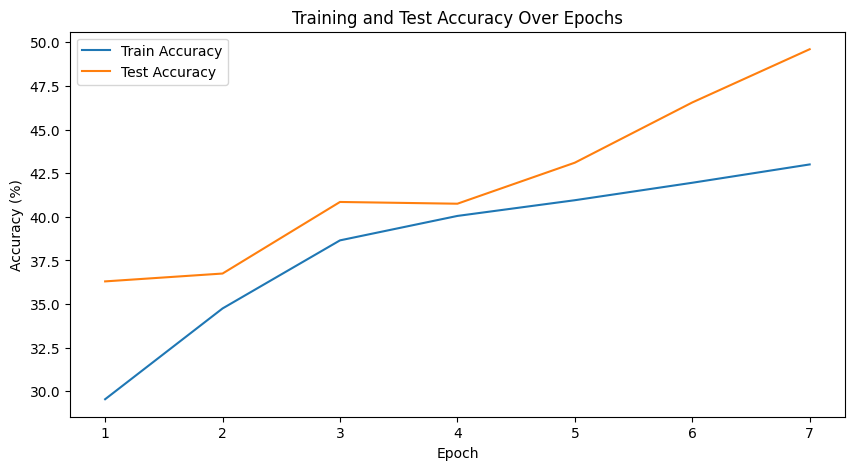

In [49]:
model_wide_resnet50_darkonly = wide_resnet50_2(pretrained=False)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50_darkonly.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50_darkonly.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50_darkonly.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50_darkonly.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
print(model_wide_resnet50_darkonly)

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly.parameters(), lr=0.002, momentum=0.9)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(7):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 8), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 31.45%


100%|██████████| 200/200 [00:07<00:00, 28.40it/s]


Test Accuracy: 40.40%
Epoch: 2


100%|██████████| 200/200 [00:21<00:00,  9.32it/s]


Train Accuracy: 36.25%


100%|██████████| 200/200 [00:07<00:00, 28.35it/s]


Test Accuracy: 37.45%
Epoch: 3


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 38.55%


100%|██████████| 200/200 [00:07<00:00, 27.93it/s]


Test Accuracy: 41.25%
Epoch: 4


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


Train Accuracy: 38.75%


100%|██████████| 200/200 [00:07<00:00, 28.12it/s]


Test Accuracy: 43.25%
Epoch: 5


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 40.65%


100%|██████████| 200/200 [00:07<00:00, 28.37it/s]


Test Accuracy: 47.20%
Epoch: 6


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


Train Accuracy: 42.05%


100%|██████████| 200/200 [00:07<00:00, 28.44it/s]


Test Accuracy: 49.40%
Epoch: 7


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 44.75%


100%|██████████| 200/200 [00:07<00:00, 28.29it/s]


Test Accuracy: 46.60%
Epoch: 8


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]


Train Accuracy: 44.50%


100%|██████████| 200/200 [00:07<00:00, 28.37it/s]


Test Accuracy: 46.65%
Epoch: 9


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 43.75%


100%|██████████| 200/200 [00:07<00:00, 28.29it/s]


Test Accuracy: 51.00%
Epoch: 10


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 46.65%


100%|██████████| 200/200 [00:07<00:00, 28.15it/s]


Test Accuracy: 45.50%
Epoch: 11


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 45.70%


100%|██████████| 200/200 [00:07<00:00, 28.23it/s]


Test Accuracy: 51.95%
Epoch: 12


100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


Train Accuracy: 47.25%


100%|██████████| 200/200 [00:07<00:00, 28.23it/s]


Test Accuracy: 49.25%


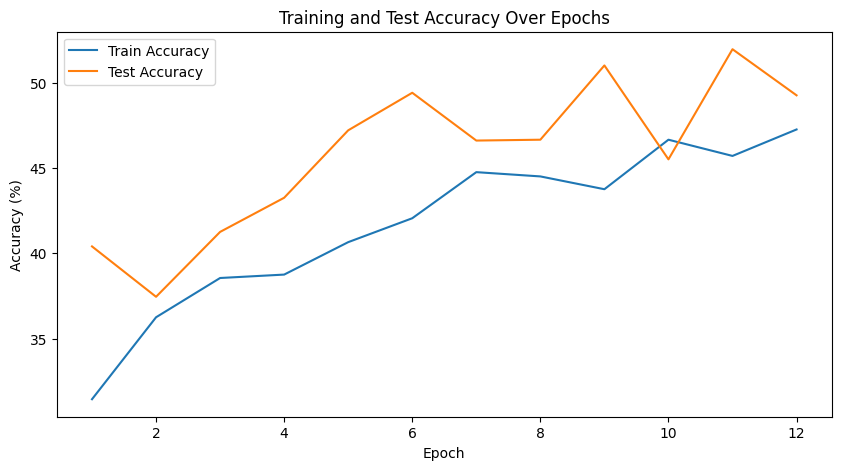

In [51]:
# 学習結果が安定的なので、ハイパーパラメータはそのままで反復回数を増加する

# torchvision より実装済みの WideResNet50 を呼び出し

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly.parameters(), lr=0.002, momentum=0.9)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(12):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 13), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




In [ ]:
# 学習結果が50%の精度を上回らないので、パラメータを調整してみる

# torchvision より実装済みの WideResNet50 を呼び出し

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly.parameters(), lr=0.002, momentum=0.8)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(12):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 13), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




通常のResnet50では分類タスクが解けないことが分かった。
そこでまず、エッジ検出を行う

学習データのサンプル:


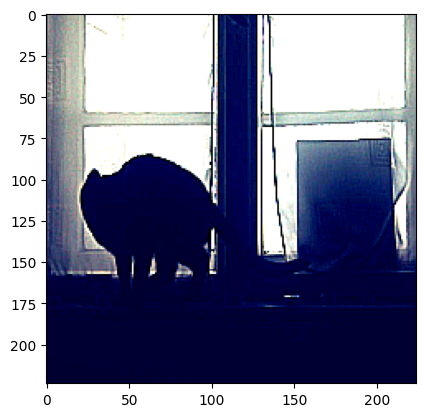

ラベル: Cat


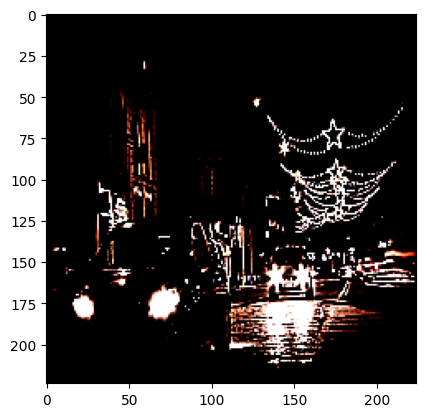

ラベル: Car


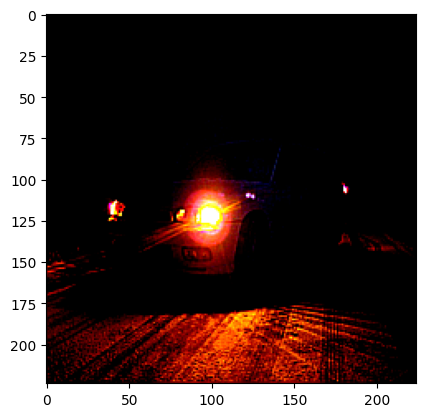

ラベル: Car


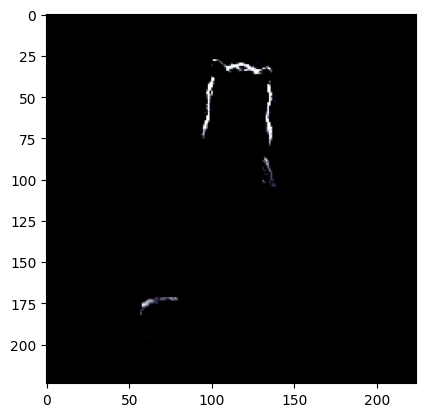

ラベル: Cat
テストデータのサンプル:


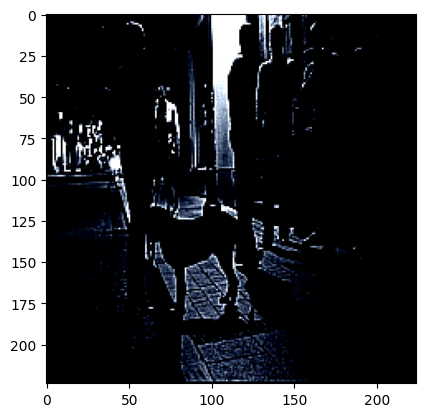

ラベル: Dog


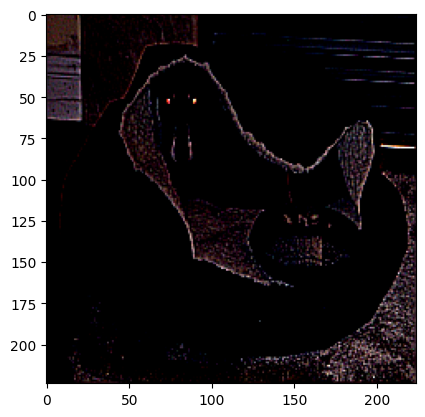

ラベル: Dog


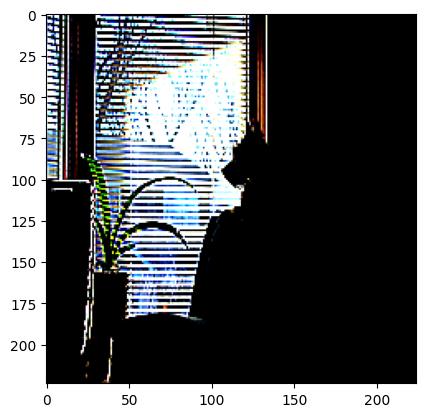

ラベル: Dog


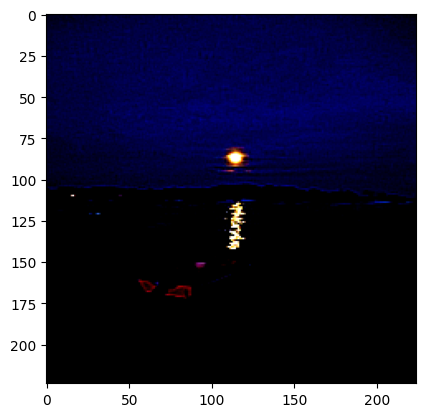

ラベル: Boat


In [74]:
import os
from PIL import Image, ImageFilter
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# データセットのパス
dataset_path = "/content/dark_images"

# カテゴリのマッピング
categories = {
    'Dog': 0,
    'Cat': 1,
    'Boat': 2,
    'Car': 3
}

# クラスラベルのリスト
class_names = list(categories.keys())

# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 8

# エッジ強調フィルターを施すためのカスタムTransformの定義
class EdgeEnhance:
    def __call__(self, image):
        edge_enhanced_image = image.filter(ImageFilter.EDGE_ENHANCE)
        return edge_enhanced_image

# 前処理の設定（エッジ強調フィルターを含む）
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    EdgeEnhance(),  # エッジ強調フィルターの適用
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# カスタムデータセットクラスの定義
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.paths = []

        for category in categories.keys():
            category_path = os.path.join(root_dir, category)
            label = categories[category]
            for root, _, files in os.walk(category_path):
                for file in files:
                    if file.endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(root, file)
                        self.images.append(img_path)
                        self.labels.append(label)
                        self.paths.append(img_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# データセットの作成
dataset_edge = CustomDataset(root_dir=dataset_path, transform=data_transform)

# データローダの作成
data_loader_edge = DataLoader(dataset_edge, batch_size=batch_size, shuffle=True, num_workers=2)


# 画像を表示する関数
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 各クラスのサンプルを表示する関数
def show_samples(loader, class_names, num_samples=4):
    dataiter = iter(loader)
    images, labels, = next(dataiter)

    # バッチから指定した数のサンプルを表示
    for i in range(num_samples):
        imshow(images[i])
        print(f'ラベル: {class_names[labels[i].item()]}')

# 学習データのサンプルを表示
print("学習データのサンプル:")
show_samples(data_loader_edge, class_names, num_samples=4)

# テストデータのサンプルを表示
print("テストデータのサンプル:")
show_samples(data_loader_edge, class_names, num_samples=4)


In [75]:
model_wide_resnet50_darkonly_edgeenhanced = wide_resnet50_2(pretrained=False)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50_darkonly_edgeenhanced.layer1 = nn.Sequential(
    WideBottleneck(64, 64, downsample=True),
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50_darkonly_edgeenhanced.layer2 = nn.Sequential(
    WideBottleneck(256, 128,downsample=True, stride=2),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50_darkonly_edgeenhanced.layer3 = nn.Sequential(
    WideBottleneck(512, 256,downsample=True, stride=2),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50_darkonly_edgeenhanced.layer4 = nn.Sequential(
    WideBottleneck(1024, 512,downsample=True, stride=2),
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
print(model_wide_resnet50_darkonly_edgeenhanced)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): WideBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

Epoch: 1


100%|██████████| 328/328 [00:30<00:00, 10.73it/s]


Train Accuracy: 48.68%


100%|██████████| 328/328 [00:15<00:00, 20.91it/s]


Test Accuracy: 53.42%
Epoch: 2


100%|██████████| 328/328 [00:28<00:00, 11.40it/s]


Train Accuracy: 50.17%


100%|██████████| 328/328 [00:16<00:00, 20.48it/s]


Test Accuracy: 56.24%
Epoch: 3


100%|██████████| 328/328 [00:28<00:00, 11.33it/s]


Train Accuracy: 53.34%


100%|██████████| 328/328 [00:15<00:00, 21.09it/s]


Test Accuracy: 58.11%
Epoch: 4


100%|██████████| 328/328 [00:29<00:00, 11.30it/s]


Train Accuracy: 55.86%


100%|██████████| 328/328 [00:15<00:00, 20.92it/s]


Test Accuracy: 58.84%
Epoch: 5


100%|██████████| 328/328 [00:29<00:00, 11.25it/s]


Train Accuracy: 54.68%


100%|██████████| 328/328 [00:15<00:00, 21.07it/s]


Test Accuracy: 56.82%
Epoch: 6


100%|██████████| 328/328 [00:29<00:00, 11.22it/s]


Train Accuracy: 56.47%


100%|██████████| 328/328 [00:15<00:00, 20.89it/s]


Test Accuracy: 61.51%
Epoch: 7


100%|██████████| 328/328 [00:29<00:00, 11.21it/s]


Train Accuracy: 59.49%


100%|██████████| 328/328 [00:15<00:00, 20.97it/s]


Test Accuracy: 66.51%
Epoch: 8


100%|██████████| 328/328 [00:29<00:00, 11.21it/s]


Train Accuracy: 58.88%


100%|██████████| 328/328 [00:15<00:00, 21.03it/s]


Test Accuracy: 62.24%
Epoch: 9


100%|██████████| 328/328 [00:29<00:00, 11.19it/s]


Train Accuracy: 61.55%


100%|██████████| 328/328 [00:15<00:00, 21.03it/s]


Test Accuracy: 70.83%
Epoch: 10


100%|██████████| 328/328 [00:29<00:00, 11.20it/s]


Train Accuracy: 63.42%


100%|██████████| 328/328 [00:15<00:00, 20.95it/s]


Test Accuracy: 67.74%
Epoch: 11


100%|██████████| 328/328 [00:29<00:00, 11.17it/s]


Train Accuracy: 65.83%


100%|██████████| 328/328 [00:15<00:00, 21.21it/s]


Test Accuracy: 70.18%
Epoch: 12


100%|██████████| 328/328 [00:29<00:00, 11.16it/s]


Train Accuracy: 66.82%


100%|██████████| 328/328 [00:16<00:00, 20.34it/s]


Test Accuracy: 67.32%


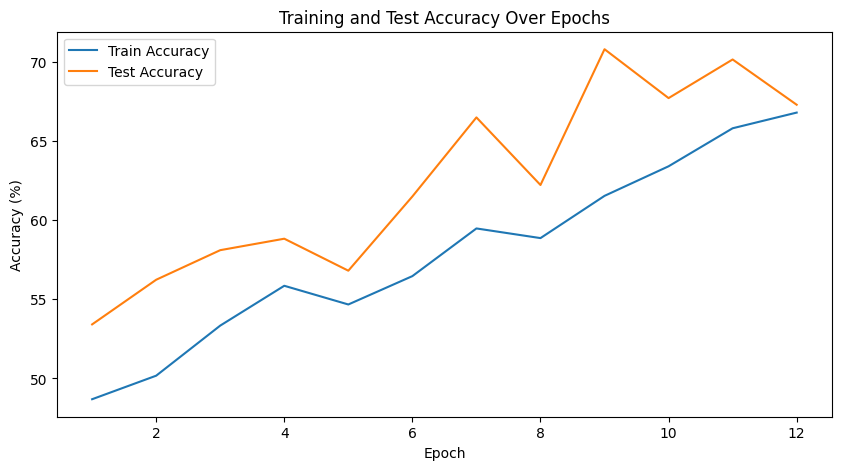

In [76]:
trainloader = torch.utils.data.DataLoader(dataset_edge, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(dataset_edge, batch_size=batch_size, shuffle=True, num_workers=2)

# optimizer
optimizer = torch.optim.SGD(model_wide_resnet50_darkonly.parameters(), lr=0.002, momentum=0.8)# 問4 #

# 損失関数
loss_fn = nn.CrossEntropyLoss()

model_wide_resnet50_darkonly.to(device)

# 精度を保存するリスト
train_accuracies = []
test_accuracies = []

for epoch in range(12):
    print("Epoch: {}".format(epoch + 1))

    # 学習モード
    model_wide_resnet50_darkonly.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50_darkonly(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 精度の計算
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print("Train Accuracy: {:.2f}%".format(train_accuracy))

    # 検証モード
    model_wide_resnet50_darkonly.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_wide_resnet50_darkonly(inputs)
            _, preds = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print("Test Accuracy: {:.2f}%".format(test_accuracy))

# 精度の遷移をプロット
plt.figure(figsize=(10, 5))
plt.plot(range(1, 13), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 13), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()




通常のResnet50による実装では、


*   50％程度で精度が頭打ちになる
*   訓練データで過剰にフィットする過学習が起きる
の二通りの失敗パターンであったが、今回は70%程度まで精度を改善することができた。

要因としては、暗闇の中で検出できる特徴量が少なく、かつ、ノイズが多かったためであると考えられる。



同様のコードで